# **Technical Challenge - Analista Sr. Applied Intelligence**
# Ejercicio 2
Sofía Cristina Aya Salazar

## 1. Revisión de bibliografía y metodologías

Se hizo una revisión inicial de las diferentes metodologías que existen para comparar cadenas de texto en el Procesamiento de Lenguaje Natural.

**1. Definiciones:**
  * Distancia:
    * Qué tan cerca o lejos están dos cadenas de texto entre sí
    * Qué tantas operaciones (ediciones) se requieren para convertir un texto en el otro
      * Dichas operaciones pueden ser: inserción, eliminación, sustitución, transposición
  * Distancia normalizada:
    * Se divide entre el tamaño de caracteres de la cadena más larga comparada, para hacer una comparación justa entre textos sin importar la longitud
  * Similitud:
    * Inversa (1 - ) de la distancia normalizada
  * Distancia de Hamming:
    * Se comparan las cadenas de texto haciendo un conteo del número de posiciones en las que los caracteres son distintos. Una restricción es que ambas cadenas deben tener el mismo tamaño (es como si se contaran el número de sustituciones, no inserciones ni eliminados)
  * Distancia de Levenshtein:
    * Número mínimo de operaciones de edición que se necesitan para pasar de una cadena de texto a la otra, sin la restricción del mismo largo en ambos textos. La implementación usa programación dinámica (discretiza y trabaja en secuencia problemas de optimización complejos) en la que se almacena en una matriz los resultados intermedios de los caracteres de los textos a comparar. La esquina inferior de la matriz tiene el valor de la distancia
  * Alineación óptima de cadenas (OSA):
    * Similar a Levenshtein, pero incluyendo transposición como operación válida
  * Damerau Levenshtein:
    * Versión no restringida de la OSA (considera transposiciones adyacentes). Es usada en procesamiento de lenguaje natural
  * Jaccard:
    * Opera sobre conjuntos; es decir, oraciones o párrafos. También puede aplicarse a palabras si se considera que son conjuntos de letras. Dicha división entre los conjuntos es llamada tokenización. En este caso, la fórmula da la similitud, por lo que la distancia sería 1-Jaccard. Un problema de este es que considera que ‘abcd’ es igual a ‘dcba’ porque contienen los mismos caracteres
  * Bag od words:
    * BoW es una técnica de extracción de características. Se basa en crear un conjunto no estructurado de todas las palabras conocidas en un documento, considerando solo la frecuencia y no el orden o contexto
  * Similitud de coseno:
    * Es una medida de similitud que se calcula entre dos vectores distintos de cero dentro del espacio interno del producto que mide el coseno del ángulo entre ellos.

**2. Temas a considerar:**
  * La distancia entre dos textos no puede ser negativa
  * La distancia entre X y Y es la misma que de Y y X
  * Una distancia de 0 entre X y Y implica que X = Y

**3. Referencias:**
  * https://medium.com/@diego.campos.sobrino/m%C3%A9tricas-de-similitud-para-cadenas-de-texto-parte-i-introducci%C3%B3n-ba252fa64827
  * https://medium.com/@diego.campos.sobrino/m%C3%A9tricas-de-similitud-para-cadenas-de-texto-parte-ii-m%C3%A9tricas-basadas-en-operaciones-de-edici%C3%B3n-af9c8aa71bdb
  * https://www.ibm.com/es-es/topics/bag-of-words#:~:text=La%20bolsa%20de%20palabras%20(BoW,de%20informaci%C3%B3n%20y%20machine%20learning%20.
  * https://www.grapheverywhere.com/algoritmo-de-similitud-de-coseno/

## 2. Importar paquetes

In [1]:
!pip install nltk
!pip install unidecode
!pip install stop-words

In [2]:
import re
import nltk
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegolaiton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Cargue de Datos

In [3]:
path_train = 'items_titles.csv'
path_test = 'items_titles_test.csv'

train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

# Se crea una copia para tener los datos sin modificaciones en el script
train_original = train.copy()
test_original = test.copy()

## 4. Vista inicial de los Datos (train)

In [4]:
train.head(5)

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Vermelho
1,Tenis Para Caminhada Super Levinho Spider Corrida
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve


In [5]:
train.isna().sum()

ITE_ITEM_TITLE    0
dtype: int64

## 5. Tratamiento de los datos

Lo primero es tratar de estandarizar los textos lo más posible. Dicha homogeneización permite comparar más fácilmente los campos. En este caso, se tratará de unificar el texto con las siguientes modificaciones:
*   Conversión de todas las palabras a minúsculas, ya que la diferencia con las mayúsculas no es relevante para el ejercicio en cuestión
*   Eliminar caracteres no deseados (tildes, signos de puntuación, símbolos, espacios en blanco, números)
*   Eliminar palabras "de apoyo" (artículos como "la", "un", "el", ... en portugués)
*   División de los títulos en palabras para facilitar la comparación y cálculo de similitud

Estas pruebas se harán paso a paso con el fin de poder observar el cambio que generan en el texto y más adelante se construirá una función que las incluya todas

In [6]:
# Se pasan todas las letras a minúsculas
train['title'] = train['ITE_ITEM_TITLE'].str.lower()
train.iloc[[8, 74, 100, 1647, 4945, 6030, 6048, 6913, 8129, 8377]]

,ITE_ITEM_TITLE,title
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tênis usthemp short temático - maria vira-lata 2
74,3pcs Mini Clubes De Golfe Caneta Esferográfica Set Com Bola,3pcs mini clubes de golfe caneta esferográfica set com bola
100,//kit 2 Pares De Tênis Fé Estiloso De Perfeita Qualidade//,//kit 2 pares de tênis fé estiloso de perfeita qualidade//
1647,//kit 3 Pares De Tênis Fé Estiloso De Belíssima Qualidade//,//kit 3 pares de tênis fé estiloso de belíssima qualidade//
4945,"1 Par De Protetor De Calcanhar Sebs, Tamanho: Tamanho Livre","1 par de protetor de calcanhar sebs, tamanho: tamanho livre"
6030,!!!mega Promoção!!! Tenis Polo Original Sport P/ Exercicio,!!!mega promoção!!! tenis polo original sport p/ exercicio
6048,03 Pares Tênis Feminino Dona Beja Lançamento Promoção,03 pares tênis feminino dona beja lançamento promoção
6913,02 Tenis Calçados Masculinos Trilha Moto Trabalho Caminhada2,02 tenis calçados masculinos trilha moto trabalho caminhada2
8129,//sapatênis Masculino Material Super Forte De Boa Qualide//,//sapatênis masculino material super forte de boa qualide//
8377,1 Tenis Meia,1 tenis meia


In [7]:
# Se eliminan las tildes al pasar el texto a ASCII
train['title'] = train['title'].apply(lambda x: unidecode.unidecode(x))
train.iloc[[8, 74, 100, 1647, 4945, 6030, 6048, 6913, 8129, 8377]]

,ITE_ITEM_TITLE,title
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tenis usthemp short tematico - maria vira-lata 2
74,3pcs Mini Clubes De Golfe Caneta Esferográfica Set Com Bola,3pcs mini clubes de golfe caneta esferografica set com bola
100,//kit 2 Pares De Tênis Fé Estiloso De Perfeita Qualidade//,//kit 2 pares de tenis fe estiloso de perfeita qualidade//
1647,//kit 3 Pares De Tênis Fé Estiloso De Belíssima Qualidade//,//kit 3 pares de tenis fe estiloso de belissima qualidade//
4945,"1 Par De Protetor De Calcanhar Sebs, Tamanho: Tamanho Livre","1 par de protetor de calcanhar sebs, tamanho: tamanho livre"
6030,!!!mega Promoção!!! Tenis Polo Original Sport P/ Exercicio,!!!mega promocao!!! tenis polo original sport p/ exercicio
6048,03 Pares Tênis Feminino Dona Beja Lançamento Promoção,03 pares tenis feminino dona beja lancamento promocao
6913,02 Tenis Calçados Masculinos Trilha Moto Trabalho Caminhada2,02 tenis calcados masculinos trilha moto trabalho caminhada2
8129,//sapatênis Masculino Material Super Forte De Boa Qualide//,//sapatenis masculino material super forte de boa qualide//
8377,1 Tenis Meia,1 tenis meia


In [8]:
# Se eliminan los caracteres que no sean alfabéticos o espacios y se reemplazan por vacío
train['title'] = train['title'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
train.iloc[[8, 74, 100, 1647, 4945, 6030, 6048, 6913, 8129, 8377]]

,ITE_ITEM_TITLE,title
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tenis usthemp short tematico maria viralata
74,3pcs Mini Clubes De Golfe Caneta Esferográfica Set Com Bola,pcs mini clubes de golfe caneta esferografica set com bola
100,//kit 2 Pares De Tênis Fé Estiloso De Perfeita Qualidade//,kit pares de tenis fe estiloso de perfeita qualidade
1647,//kit 3 Pares De Tênis Fé Estiloso De Belíssima Qualidade//,kit pares de tenis fe estiloso de belissima qualidade
4945,"1 Par De Protetor De Calcanhar Sebs, Tamanho: Tamanho Livre",par de protetor de calcanhar sebs tamanho tamanho livre
6030,!!!mega Promoção!!! Tenis Polo Original Sport P/ Exercicio,mega promocao tenis polo original sport p exercicio
6048,03 Pares Tênis Feminino Dona Beja Lançamento Promoção,pares tenis feminino dona beja lancamento promocao
6913,02 Tenis Calçados Masculinos Trilha Moto Trabalho Caminhada2,tenis calcados masculinos trilha moto trabalho caminhada
8129,//sapatênis Masculino Material Super Forte De Boa Qualide//,sapatenis masculino material super forte de boa qualide
8377,1 Tenis Meia,tenis meia


In [9]:
# Se eliminan posibles múltiples espacios, dejando solo uno
train['title'] = train['title'].apply(lambda x: re.sub(r'\s+', ' ', x))
train.iloc[[8, 74, 100, 1647, 4945, 6030, 6048, 6913, 8129, 8377]]

,ITE_ITEM_TITLE,title
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tenis usthemp short tematico maria viralata
74,3pcs Mini Clubes De Golfe Caneta Esferográfica Set Com Bola,pcs mini clubes de golfe caneta esferografica set com bola
100,//kit 2 Pares De Tênis Fé Estiloso De Perfeita Qualidade//,kit pares de tenis fe estiloso de perfeita qualidade
1647,//kit 3 Pares De Tênis Fé Estiloso De Belíssima Qualidade//,kit pares de tenis fe estiloso de belissima qualidade
4945,"1 Par De Protetor De Calcanhar Sebs, Tamanho: Tamanho Livre",par de protetor de calcanhar sebs tamanho tamanho livre
6030,!!!mega Promoção!!! Tenis Polo Original Sport P/ Exercicio,mega promocao tenis polo original sport p exercicio
6048,03 Pares Tênis Feminino Dona Beja Lançamento Promoção,pares tenis feminino dona beja lancamento promocao
6913,02 Tenis Calçados Masculinos Trilha Moto Trabalho Caminhada2,tenis calcados masculinos trilha moto trabalho caminhada
8129,//sapatênis Masculino Material Super Forte De Boa Qualide//,sapatenis masculino material super forte de boa qualide
8377,1 Tenis Meia,tenis meia


In [10]:
# Lista de stop_words en portugués
stops1 = get_stop_words('portuguese')
stops2 = set(stopwords.words('portuguese'))
stop_words = sorted(list(set(stops1 + list(stops2))))

# Eliminar 'stopwords'
train['title'] = train['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train.iloc[[8, 74, 100, 1647, 4945, 6030, 6048, 6913, 8129, 8377]]

,ITE_ITEM_TITLE,title
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tenis usthemp short tematico maria viralata
74,3pcs Mini Clubes De Golfe Caneta Esferográfica Set Com Bola,pcs mini clubes golfe caneta esferografica set bola
100,//kit 2 Pares De Tênis Fé Estiloso De Perfeita Qualidade//,kit pares tenis fe estiloso perfeita qualidade
1647,//kit 3 Pares De Tênis Fé Estiloso De Belíssima Qualidade//,kit pares tenis fe estiloso belissima qualidade
4945,"1 Par De Protetor De Calcanhar Sebs, Tamanho: Tamanho Livre",par protetor calcanhar sebs tamanho tamanho livre
6030,!!!mega Promoção!!! Tenis Polo Original Sport P/ Exercicio,mega promocao tenis polo original sport p exercicio
6048,03 Pares Tênis Feminino Dona Beja Lançamento Promoção,pares tenis feminino dona beja lancamento promocao
6913,02 Tenis Calçados Masculinos Trilha Moto Trabalho Caminhada2,tenis calcados masculinos trilha moto trabalho caminhada
8129,//sapatênis Masculino Material Super Forte De Boa Qualide//,sapatenis masculino material super forte boa qualide
8377,1 Tenis Meia,tenis meia


In [11]:
# Partición de los títulos en palabras (tokens)
train['title'] = train['title'].apply(lambda x: x.split())
train.iloc[[8, 74, 100, 1647, 4945, 6030, 6048, 6913, 8129, 8377]]

,ITE_ITEM_TITLE,title
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,"[tenis, usthemp, short, tematico, maria, viralata]"
74,3pcs Mini Clubes De Golfe Caneta Esferográfica Set Com Bola,"[pcs, mini, clubes, golfe, caneta, esferografica, set, bola]"
100,//kit 2 Pares De Tênis Fé Estiloso De Perfeita Qualidade//,"[kit, pares, tenis, fe, estiloso, perfeita, qualidade]"
1647,//kit 3 Pares De Tênis Fé Estiloso De Belíssima Qualidade//,"[kit, pares, tenis, fe, estiloso, belissima, qualidade]"
4945,"1 Par De Protetor De Calcanhar Sebs, Tamanho: Tamanho Livre","[par, protetor, calcanhar, sebs, tamanho, tamanho, livre]"
6030,!!!mega Promoção!!! Tenis Polo Original Sport P/ Exercicio,"[mega, promocao, tenis, polo, original, sport, p, exercicio]"
6048,03 Pares Tênis Feminino Dona Beja Lançamento Promoção,"[pares, tenis, feminino, dona, beja, lancamento, promocao]"
6913,02 Tenis Calçados Masculinos Trilha Moto Trabalho Caminhada2,"[tenis, calcados, masculinos, trilha, moto, trabalho, caminhada]"
8129,//sapatênis Masculino Material Super Forte De Boa Qualide//,"[sapatenis, masculino, material, super, forte, boa, qualide]"
8377,1 Tenis Meia,"[tenis, meia]"


Ahora que ya se revisó el procesamiento del texto paso a paso, se creará una función que lo haga

In [12]:
# Procesamiento del texto
def process_text(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  text = ' '.join([word for word in text.split() if word not in (stop_words)])
  tokens = text.split()
  return text, tokens

# # Si no estuvieran las celdas anteriores, sería necesario correr esto para generar la lista de stop_words:
# stops1 = get_stop_words('portuguese')
# stops2 = set(stopwords.words('portuguese'))
# stop_words = sorted(list(set(stops1 + list(stops2))))

train[['title', 'tokens']] = train['ITE_ITEM_TITLE'].apply(lambda x: pd.Series(process_text(x)))
train

,ITE_ITEM_TITLE,title,tokens
0,Tênis Ascension Posh Masculino - Preto E Vermelho,tenis ascension posh masculino preto vermelho,"[tenis, ascension, posh, masculino, preto, vermelho]"
1,Tenis Para Caminhada Super Levinho Spider Corrida,tenis caminhada super levinho spider corrida,"[tenis, caminhada, super, levinho, spider, corrida]"
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,tenis feminino le parc hocks blackice original envio ja,"[tenis, feminino, le, parc, hocks, blackice, original, envio, ja]"
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,tenis olympikus esportivo academia nova tendencia triunfo,"[tenis, olympikus, esportivo, academia, nova, tendencia, triunfo]"
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,inteligente led bicicleta tauda luz usb bicicleta carregave,"[inteligente, led, bicicleta, tauda, luz, usb, bicicleta, carregave]"
...,...,...,...
29995,Tênis Vans Old Skool I Love My Vans - Usado - Feminino,tenis vans old skool i love my vans usado feminino,"[tenis, vans, old, skool, i, love, my, vans, usado, feminino]"
29996,Tênis Feminino Preto Moleca 5296155,tenis feminino preto moleca,"[tenis, feminino, preto, moleca]"
29997,Tenis Botinha Com Pelo Via Marte Original Lançamento,tenis botinha via marte original lancamento,"[tenis, botinha, via, marte, original, lancamento]"
29998,Tênis Slip On Feminino Masculino Original Sapato Xadrez Mule,tenis slip on feminino masculino original sapato xadrez mule,"[tenis, slip, on, feminino, masculino, original, sapato, xadrez, mule]"


## 6. Visualización de tokens

Para tener una mejor idea de los tokens (palabras) que se tienen en el dataset, se creará una nube de palabras. Esto requiere que se tenga la frecuencia del set único de tokens:

In [13]:
lista_tokens = train['tokens'].sum()
freq_tokens = Counter(lista_tokens)
freq_tokens.most_common(10)

[('tenis', 22584),
 ('feminino', 7901),
 ('masculino', 5326),
 ('casual', 3747),
 ('infantil', 3478),
 ('preto', 3106),
 ('original', 2750),
 ('sapatenis', 2626),
 ('bicicleta', 2243),
 ('aro', 1678)]

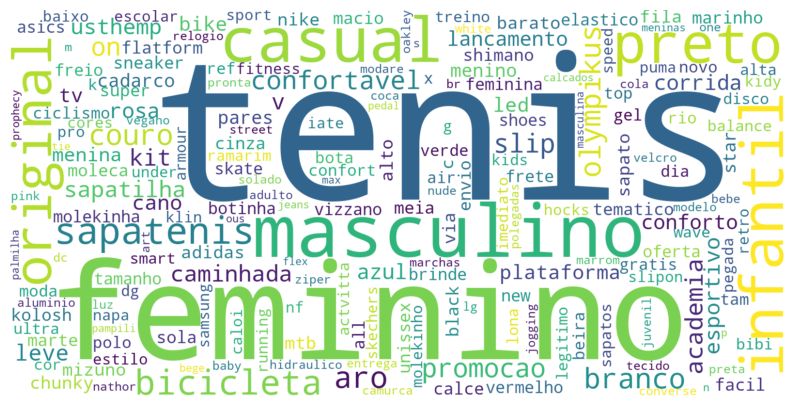

In [14]:
# Nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, background_color = "white").generate_from_frequencies(freq_tokens)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## 7. Implementación de Metodología

Con base en la revisión de métricas y métodos realizada, se toma la decisión de hacer un "Bag of Words", pues se prioriza la frecuencia de las palabras y no tanto el orden. Para determinar la similitud entre los títulos se usará la Similitud de Coseno, por lo que a continuación se convertirán en vectores los títulos y se realizarán los cálculos respectivos

In [15]:
# lista_tokens no es una lista de palabras únicas, sino que tiene en consideración la cantidad de veces que se repite c/u
# Esto era necesario para la nube de palabras; sin embargo, para el BoW se necesita tener el vocabulario único del dataframe
vocabulario = sorted(pd.Series(lista_tokens).drop_duplicates().tolist())

# Creación de vectores para cada uno de los títulos
train['vector1'] = train['tokens'].apply(lambda token: [token.count(palabra) for palabra in vocabulario]) # Vector completo de frecuencia
train['vector2'] = [Counter(tokens) for tokens in train['tokens']] # Vector simplificado

In [16]:
# Aquí se observa la diferencia entre los dos vectores creados
print("Si bien la idea del Bag of Words es crear los vectores que consideren todas las palabras en la bolsa, esto en realidad se torna en vectores de gran tamaño \
que requieren de muchos recursos para calcular la matriz de similitud. Por tal razón, se buscó una alternativa (vector2) en donde solo se consideran las palabras \
realmente presentes en cada título, las cuales posteriormente serán usadas para calcular el producto punto y demás valores de la métrica de similitud.")
train.head(5)

Si bien la idea del Bag of Words es crear los vectores que consideren todas las palabras en la bolsa, esto en realidad se torna en vectores de gran tamaño que requieren de muchos recursos para calcular la matriz de similitud. Por tal razón, se buscó una alternativa (vector2) en donde solo se consideran las palabras realmente presentes en cada título, las cuales posteriormente serán usadas para calcular el producto punto y demás valores de la métrica de similitud.


,ITE_ITEM_TITLE,title,tokens,vector1,vector2
0,Tênis Ascension Posh Masculino - Preto E Vermelho,tenis ascension posh masculino preto vermelho,"[tenis, ascension, posh, masculino, preto, vermelho]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","{'tenis': 1, 'ascension': 1, 'posh': 1, 'masculino': 1, 'preto': 1, 'vermelho': 1}"
1,Tenis Para Caminhada Super Levinho Spider Corrida,tenis caminhada super levinho spider corrida,"[tenis, caminhada, super, levinho, spider, corrida]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","{'tenis': 1, 'caminhada': 1, 'super': 1, 'levinho': 1, 'spider': 1, 'corrida': 1}"
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,tenis feminino le parc hocks blackice original envio ja,"[tenis, feminino, le, parc, hocks, blackice, original, envio, ja]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","{'tenis': 1, 'feminino': 1, 'le': 1, 'parc': 1, 'hocks': 1, 'blackice': 1, 'original': 1, 'envio': 1, 'ja': 1}"
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,tenis olympikus esportivo academia nova tendencia triunfo,"[tenis, olympikus, esportivo, academia, nova, tendencia, triunfo]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","{'tenis': 1, 'olympikus': 1, 'esportivo': 1, 'academia': 1, 'nova': 1, 'tendencia': 1, 'triunfo': 1}"
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,inteligente led bicicleta tauda luz usb bicicleta carregave,"[inteligente, led, bicicleta, tauda, luz, usb, bicicleta, carregave]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","{'inteligente': 1, 'led': 1, 'bicicleta': 2, 'tauda': 1, 'luz': 1, 'usb': 1, 'carregave': 1}"


In [17]:
# Calcular la similitud entre títulos con Similitud de Coseno (vector completo)
def similitud_completo(vector1, vector2):
  ppunto = np.dot(vector1, vector2)
  magnitud1 = np.linalg.norm(vector1)
  magnitud2 = np.linalg.norm(vector2)

  if (magnitud1==0) or (magnitud2==0):
    return 0
  else:
    return (ppunto/(magnitud1*magnitud2))

# Calcular la similitud entre títulos con Similitud de Coseno (vector simplificado)
def similitud_simplificado(vector1, vector2):
  comunes = set(vector1.keys()).intersection(set(vector2.keys()))
  ppunto = sum([vector1[palabra]*vector2[palabra] for palabra in comunes])
  magnitud1 = np.linalg.norm(np.array(list(vector1.values())))
  magnitud2 = np.linalg.norm(np.array(list(vector2.values())))

  if (magnitud1==0) or (magnitud2==0):
    return 0
  else:
    return (ppunto/(magnitud1*magnitud2))

In [18]:
%%time

# ----------------------------------- Esto toma mucho tiempo -----------------------------------
# # Implementar el cálculo de similitud para todos los posibles pares de títulos (vector completo)
# pares = []
# for i in range(len(train)):
#   for j in range(i + 1, len(train)):
#     score = similitud_completo(train['vector1'].iloc[i], train['vector1'].iloc[j])
#     pares.append((train['ITE_ITEM_TITLE'].iloc[i], train['ITE_ITEM_TITLE'].iloc[j], score))

# ----------------------------------- Alternativa simplificada -----------------------------------
# Implementar el cálculo de similitud para todos los posibles pares de títulos (vector simplificado)
pares = []
for i in range(len(train)):
  for j in range(i + 1, len(train)):
    score = similitud_simplificado(train['vector2'].iloc[i], train['vector2'].iloc[j])
    pares.append((train['ITE_ITEM_TITLE'].iloc[i], train['ITE_ITEM_TITLE'].iloc[j], score))

pares = pd.DataFrame(pares, columns = ['Título1', 'Título2', 'score'])
pares

CPU times: user 1h 28min 18s, sys: 1min 53s, total: 1h 30min 11s
Wall time: 1h 36min 24s


,Título1,Título2,score
0,Tênis Ascension Posh Masculino - Preto E Vermelho,Tenis Para Caminhada Super Levinho Spider Corrida,0.166667
1,Tênis Ascension Posh Masculino - Preto E Vermelho,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,0.136083
2,Tênis Ascension Posh Masculino - Preto E Vermelho,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,0.154303
3,Tênis Ascension Posh Masculino - Preto E Vermelho,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,0.000000
4,Tênis Ascension Posh Masculino - Preto E Vermelho,Tênis Casual Masculino Zarato 941 Preto 632,0.547723
...,...,...,...
449984995,Tênis Feminino Preto Moleca 5296155,Tênis Slip On Feminino Masculino Original Sapato Xadrez Mule,0.333333
449984996,Tênis Feminino Preto Moleca 5296155,Bicicleta Nathor Rosa Infantil Sem Pedal Balance Aro 12,0.000000
449984997,Tenis Botinha Com Pelo Via Marte Original Lançamento,Tênis Slip On Feminino Masculino Original Sapato Xadrez Mule,0.272166
449984998,Tenis Botinha Com Pelo Via Marte Original Lançamento,Bicicleta Nathor Rosa Infantil Sem Pedal Balance Aro 12,0.000000


In [19]:
pares = pares.sort_values(by = 'score', ascending = False).reset_index(drop = True)
pares.head(10)

,Título1,Título2,score
0,Tênis Infantil Molekinha 25201411,Tenis Infantil Molekinha 2501362,1.0
1,Tênis Feminino Vizzano 1354110,Tênis Feminino Vizzano 1379.101,1.0
2,Tênis Casual Feminino,Tenis Feminino Casual,1.0
3,Tênis Feminino Actvitta - 4814104,Tênis Actvitta Feminino 480211121227,1.0
4,Tênis Feminino Dad Sneaker Via Marte - 2111602,Tênis Feminino Dad Sneaker Via Marte - 2111603,1.0
5,Tenis Moleca 5740.100 Feminino,Tênis Feminino Moleca 5674.101,1.0
6,Tênis Mizuno Prophecy 8,Tênis Mizuno Prophecy,1.0
7,Tênis Preto E Branco,Tênis Preto Com Branco,1.0
8,Tenis Vizzano 1355.101 Feminino,Tênis Feminino Vizzano 1379.101,1.0
9,Tênis Masculino Feminino Bota Cano Alto 34 Ao 43,Tenis Bota Feminino Masculino Cano Alto,1.0


## 8. Unificación del proceso

In [20]:
def process_text(text, stop_words):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  text = ' '.join([word for word in text.split() if word not in (stop_words)])
  tokens = text.split()
  return text, tokens

def word_cloud(tokens_list):
  freq_tokens = Counter(tokens_list)
  wordcloud = WordCloud(width = 1600, height = 800, background_color= "white").generate_from_frequencies(freq_tokens)
  plt.figure(figsize = (10, 10))
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis("off")
  plt.show()

def cosine_similarity(vector1, vector2):
  common = set(vector1.keys()).intersection(set(vector2.keys()))
  ppunto = sum([vector1[word]*vector2[word] for word in common])
  magnitude1 = np.linalg.norm(np.array(list(vector1.values())))
  magnitude2 = np.linalg.norm(np.array(list(vector2.values())))

  if (magnitude1==0) or (magnitude2==0):
    return 0
  else:
    return (ppunto/(magnitude1*magnitude2))

def implementation(df, stop_words, col= 'ITE_ITEM_TITLE'):
  # Tratamiento de datos
  df[['title', 'tokens']] = df[col].apply(lambda x: pd.Series(process_text(x, stop_words)))

  # Nube de palabras
  tokens_list = df['tokens'].sum()
  word_cloud(tokens_list)
  df['vector'] = [Counter(tokens) for tokens in df['tokens']]

  # Cálculo de similitud
  pairs = []
  n = len(df)
  for i in range(n):
    for j in range(i + 1, n):
      score = cosine_similarity(df['vector'].iloc[i], df['vector'].iloc[j])
      pairs.append((df[col].iloc[i], df[col].iloc[j], score))

  pairs_df= pd.DataFrame(pairs, columns = ['title_1', 'title_2', 'score'])
  pairs_df = pairs_df.sort_values(by = 'score', ascending = False).reset_index(drop = True)

  return df, pairs_df

## 9. Aplicación en test

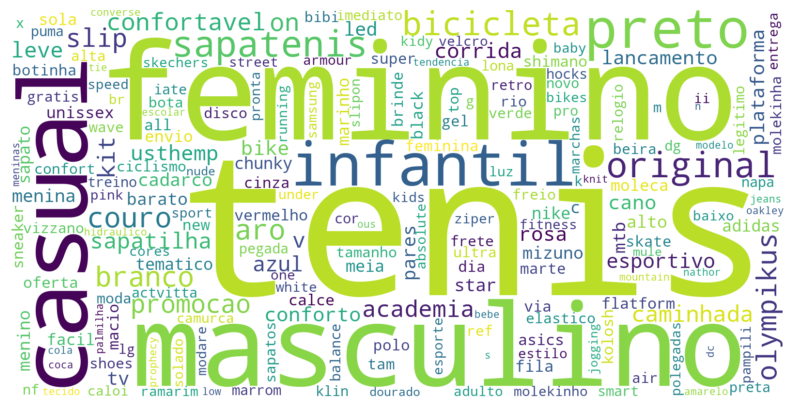

,title_1,title_2,score
0,Tênis Feminino Slip On Via Marte 20-11807,Tênis Feminino Slip On Via Marte - 2011807,1.0
1,Tênis Feminino Moleca,Tênis Moleca Feminino 5696.103,1.0
2,Tênis Feminino Actvitta - 4802103,Tênis Feminino Actvitta - 4215413,1.0
3,Tênis Feminino Activtta Cataluna Corrida Esportivo 4811,Tênis Corrida Activtta Feminino Cataluna Esportivo 4811-204,1.0
4,Tênis Fila Disruptor Ii Premium Feminino,Tênis Fila Disruptor Ii Premium Feminino 39,1.0


In [21]:
stops1 = get_stop_words('portuguese')
stops2 = set(stopwords.words('portuguese'))
stop_words = sorted(list(set(stops1 + list(stops2))))

test, pairs_test = implementation(test, stop_words, col= 'ITE_ITEM_TITLE')
pairs_test.head(5)

## 10. Conclusiones

La solución aquí propuesta es sencilla y puede ser mejorada de diversas maneras:

**Tratamiento de los datos**
*   Implementar lematización (reducir las palabras a sus raíces)
*   Hacer un filtro inicial que permita comparar los títulos solo con aquellos más probables de parecerse; por ejemplo, crear categorías como "tenis", "electrónicos", ... etc, que reduzcan el tiempo y los recursos necesarios, ya que se harían matrices de comparaciones solo para cada categoría
*   Hacer el pre-procesamiento del texto con otras consideraciones. Por ejemplo, aquí se tomó la decisión de eliminar los caracteres numéricos, ya que aunque pueden hacer referencia a ciertos modelos de tenis o el tamaño (pulgadas) de televisores, también se encontró que se usan para definir cantidades o en muchos casos son 'typos'. Igualmente, podría considerarse que aspectos como el color no son relevantes para el análisis
*   Usar otras librerías para obtener las stop-words. No es necesario utilizar las dos aquí propuestas, ni hacer el _set_ de valores únicos entre ambas
*   Crear una columna adicional que nos diga la cantidad de tokens para cada título y solo comparar aquellos vectores que tenga una longitud similar (definido por un margen)
  
**Optimización de recursos:**
*   Si bien se propuso una alternativa (vector2), tener el doble _for_ para calcular las similitudes entre todos los pares (particularmente para grandes datasets) no es muy eficiente. Por lo tanto, se recomendaría utilizar otras metodologías que sí puedan ser escalables

**Implementación en diferentes sets de datos:**
*   En el script anterior se realizó el cálculo de similitud de los textos para los títulos encontrados en dos datasets dados; sin embargo, estas comparaciones fueron 'interiores'. Dicho de otra manera, se trataron las bases como independientes, en donde el tratamiento de cada una se realizó siguiendo la misma metodología, pero creando la matriz con los valores propios de cada dataset. Si por el contrario se quisiera comparar qué tan similares son los títulos de una base y de la otra, tocaría hacer una pequeña modificación en la función de implementación:
  *   En este momento, el doble for se hace para todos los valores de _i_ [0, longitud_df), mientras que los _j_ van desde _i_+1. La razón de esto es que no es necesario hacer el cálculo del título[3] vs título[2] si ya se hizo título[2] vs título[3], puesto que los resultados serán exactamente los mismos
  *   Sin embargo, para comparar dos datasets diferentes (train y test) sería necesario considerar ambos loops como [0, longitud_df)

**Recomendaciones de textos similares:**
*   Los resultados obtenidos de la función nos arrojan la matriz de todas las parejas con su score, ordenadas de mayor a menor similitud. Sin embargo, si quisiéramos saber para un título particular cuáles son los que más se le parecen, se podría utilizar la misma lógica de la similitud del coseno pero generando únicamente las parejas que nos interesan